In [1]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

Matplotlib is building the font cache; this may take a moment.


In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

README.md: 0.00B [00:00, ?B/s]

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
dt = dls.train
xb,yb = next(iter(dt))

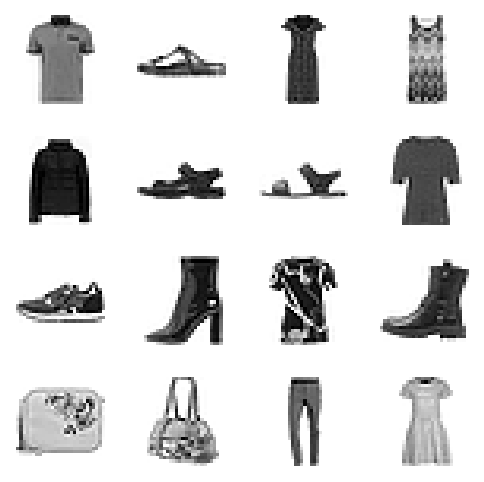

In [6]:
show_images(xb[:16], imsize=1.5)

In [7]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

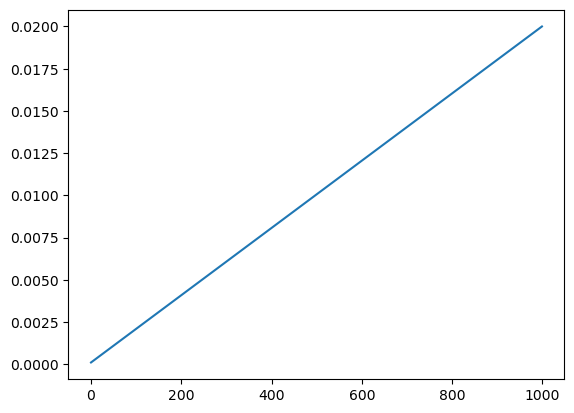

In [8]:
plt.plot(beta);

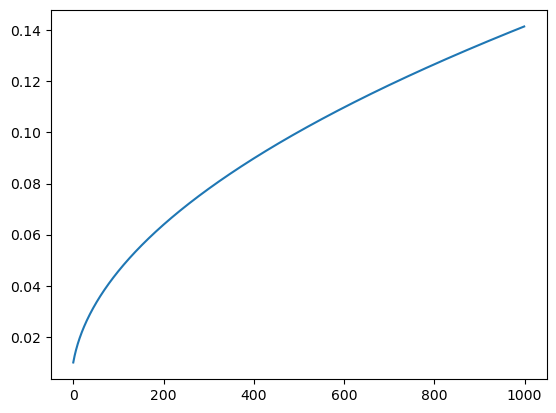

In [9]:
plt.plot(sigma);

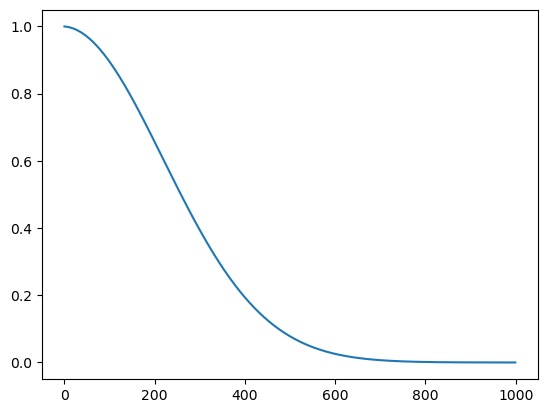

In [10]:
plt.plot(alphabar);

In [11]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [12]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([120, 305, 543, 130, 795, 160, 878, 842, 611, 342, 415, 603, 696, 726,
        381, 495, 987, 813, 239, 288,  57, 918, 990, 388, 997])

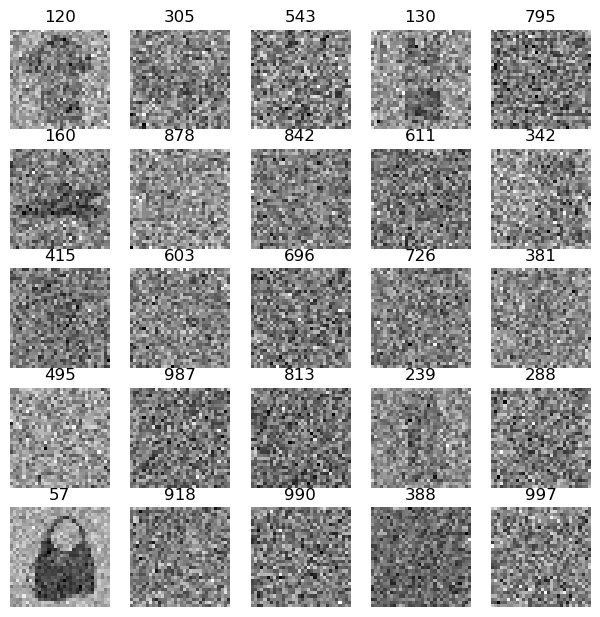

In [13]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [14]:
from diffusers import UNet2DModel

In [15]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [16]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [17]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [18]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

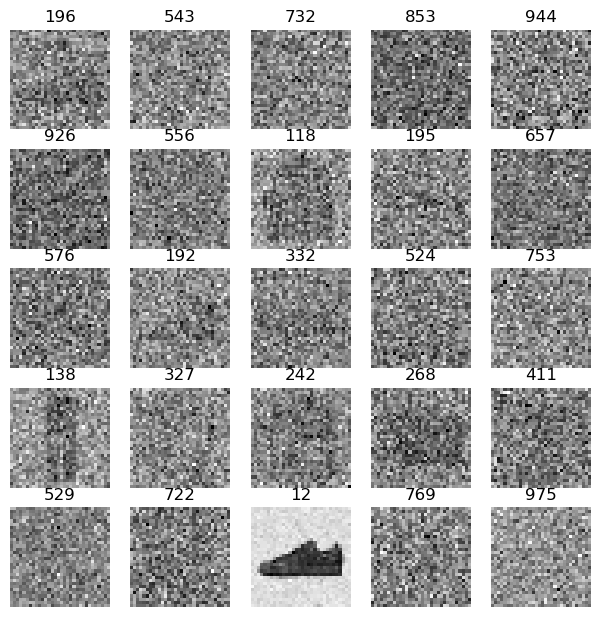

In [19]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [20]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [21]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [22]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [23]:
init_ddpm(model)

In [24]:
opt_func = partial(optim.Adam, eps=1e-5)

In [25]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.148,0,train
0.024,0,eval
0.023,1,train
0.020,1,eval
0.021,2,train
0.020,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.018,4,eval


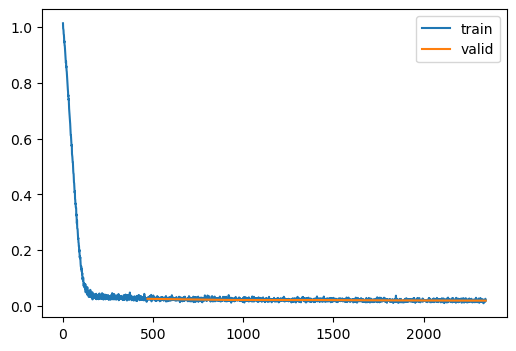

In [26]:
learn.fit(epochs)

In [27]:
mdl_path = Path('models')

In [28]:
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [29]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

/tmp/ipykernel_2996/1792878766.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')


## Sampling

In [30]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

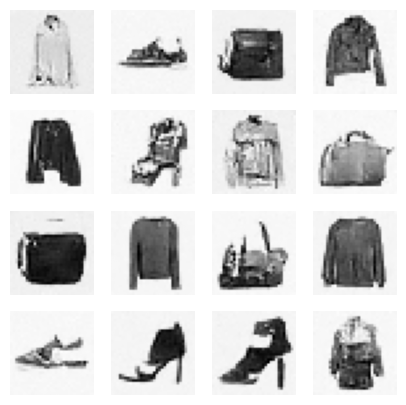

In [31]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision

In [32]:
bs = 512

In [33]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [34]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [35]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [36]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [37]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/tmp/ipykernel_2996/2894292263.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


loss,epoch,train
0.265,0,train
0.034,0,eval
0.029,1,train
0.026,1,eval
0.024,2,train
0.023,2,eval
0.021,3,train
0.022,3,eval
0.020,4,train
0.020,4,eval


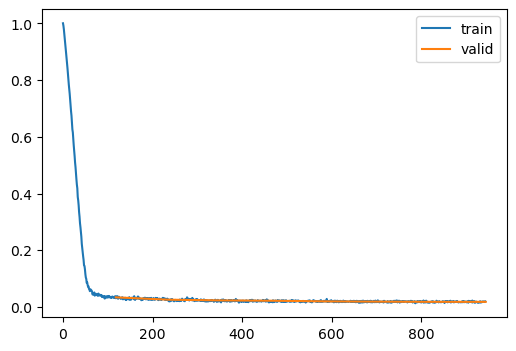

In [38]:
learn.fit(epochs)

In [39]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alphabar, sigma, n_steps)

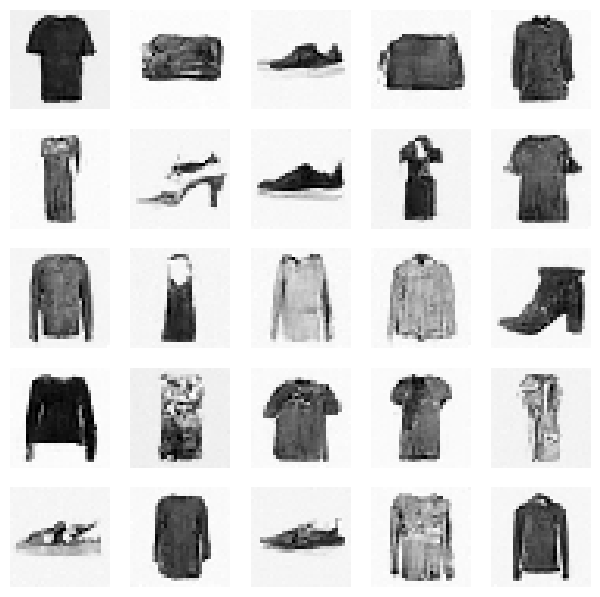

In [40]:
show_images(samples[-1][:25], imsize=1.5)

In [41]:
torch.save(learn.model, 'models/fashion_ddpm_mp.pkl')

## Accelerate

`pip install accelerate` before running this section.

In [43]:
#|export
from accelerate import Accelerator

In [44]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)

In [45]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [46]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [47]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [48]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.265,0,train
0.035,0,eval
0.030,1,train
0.027,1,eval
0.024,2,train
0.023,2,eval
0.021,3,train
0.021,3,eval
0.020,4,train
0.020,4,eval


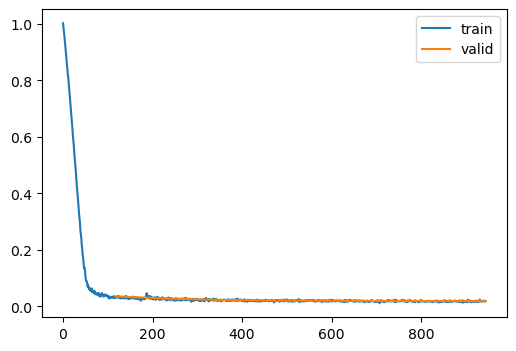

In [49]:
learn.fit(epochs)

## A sneaky trick

In [50]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [51]:
dls.train = MultDL(dls.train)

## Export -

In [52]:
import nbdev; nbdev.nbdev_export()

/venv/ml/lib/python3.12/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib
